# Import

In [12]:
# 기본 세팅
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import gaussian_kde
from matplotlib import colors as mpl_colors
import os
import argparse
from datetime import datetime
from glob import glob


# Font & Color

##### TODO
- font download

In [13]:
# font = {'family': 'Tahoma'}
# font = {'family': 'Times New Roman'}

# plt.rc('font', **font)

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

### Save format

In [14]:
save_formats = ['png', 'pdf', 'svg']
device = 'nano'
models = ['densenet201', 'resnet10']
for model in models:
    for save_format in save_formats:
        directory_path = f'./{model}/{save_format}'
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)
            print(f"디렉터리 '{directory_path}' 생성 완료!")
        else:
            print(f"디렉터리 '{directory_path}'가 이미 존재합니다.")

디렉터리 './densenet201/png'가 이미 존재합니다.
디렉터리 './densenet201/pdf'가 이미 존재합니다.
디렉터리 './densenet201/svg'가 이미 존재합니다.
디렉터리 './resnet10/png'가 이미 존재합니다.
디렉터리 './resnet10/pdf'가 이미 존재합니다.
디렉터리 './resnet10/svg'가 이미 존재합니다.


# Load csv & Dataframe 생성

In [15]:
model = 'densenet201'
date = 'data-0106'
# 파일 경로 설정
files = {
    'Seq\n(Full CPU)': f"../../csv/{date}/sequential/{model}/sequential_cpu_01core.csv",
    'TPA\n(Full CPU)': f"../../csv/{date}/pipeline/{model}/pipeline_cpu.csv",
    'DPA\n(Full CPU)': f"../../csv/{date}/data_parallel/{model}/data-parallel_cpu_4thread.csv",
    'Seq\n(Full GPU)': f"../../csv/{date}/sequential/{model}/sequential_gpu_01core.csv",
    'TPA\n(Full GPU)': f"../../csv/{date}/pipeline/{model}/pipeline_gpu.csv",
    'DPA\n(Full GPU)': f"../../csv/{date}/data_parallel/{model}/data-parallel_gpu_4thread.csv"
}

# 데이터 저장을 위한 딕셔너리
throughput = {}
average_execution_times = {}
block_losses = {}
accel_gains = {}
pre_components = {}
infer_components = {}
post_components = {}
block_components = {}

# 파일 별로 데이터 로드 및 평균 계산
for label, file_path in files.items():
    data = pd.read_csv(file_path)
    
    # frame_rate의 평균 계산
    task_num = len(data)
    start_preprocess_time = data["start_preprocess"].iloc[0]
    end_infer_time = data["end_postprocess"].iloc[-1]
    Throughput = task_num / (end_infer_time - start_preprocess_time) * 1000
    throughput[label] = Throughput
    # execution_time의 평균 계산
    average_execution_time = data['execution_time'].mean()
    average_execution_times[label] = average_execution_time
    if "waiting gpu" in data.columns:
        block_loss = data["waiting gpu"].mean()
        block_losses[label] = block_loss
    elif "e_stall" in data.columns:
        block_loss = data["e_stall"].mean()
        block_losses[label] = block_loss
    else:
        block_losses[label] = 0

    pre_component = data["e_preprocess"].mean()
    pre_components[label] = pre_component
    infer_component = data["e_infer"].mean()
    infer_components[label] = infer_component
    post_component = data["e_postprocess"].mean()
    post_components[label] = post_component
    block_components[label] = block_losses[label]

    if(label == "Seq\n(Full GPU)"):
        
        accel_gain = pre_components["Seq\n(Full CPU)"] - pre_components[label] + infer_components["Seq\n(Full CPU)"] - infer_components[label] + post_components["Seq\n(Full CPU)"] - post_components[label]
        # accel_gain = average_execution_times["Seq\n(Full CPU)"] - average_execution_times[label]
        accel_gains[label] = accel_gain
    elif(label == "TPA\n(Full GPU)"):
        accel_gain = pre_components["TPA\n(Full CPU)"] - pre_components[label] + infer_components["TPA\n(Full CPU)"] - infer_components[label] + post_components["TPA\n(Full CPU)"] - post_components[label]
        # accel_gain = average_execution_times["TPA\n(Full CPU)"] - average_execution_times[label]  
        accel_gains[label] = accel_gain
    elif(label == "DPA\n(Full GPU)"):
        accel_gain = pre_components["DPA\n(Full CPU)"] - pre_components[label] + infer_components["DPA\n(Full CPU)"] - infer_components[label] + post_components["DPA\n(Full CPU)"] - post_components[label]
        # accel_gain = average_execution_times["DPA\n(Full CPU)"] - average_execution_times[label]
        accel_gains[label] = accel_gain

    
    

# Graph

##### 1. Average Frame Rate

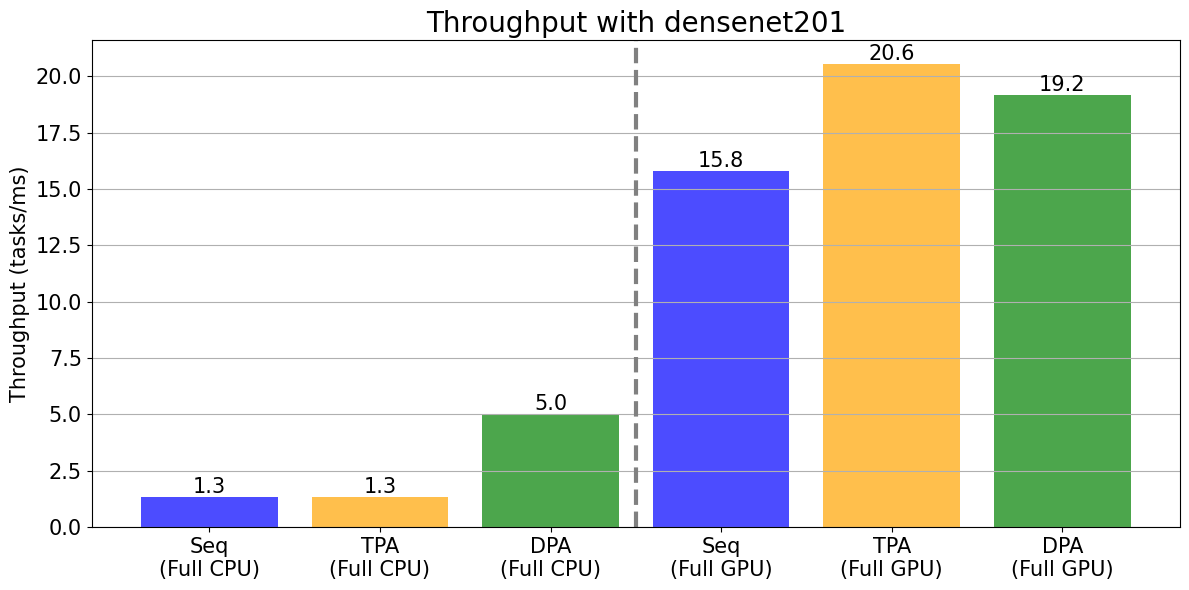

In [16]:
fig = plt.figure(figsize=(12, 6))

# 첫 번째 그래프: Average Frame Rate
bars1 = plt.bar(throughput.keys(), throughput.values(), color=colors[:3], alpha=0.7)
plt.ylabel('Throughput (tasks/ms)', size = 15)
plt.title(f'Throughput with {model}', size = 20)
plt.grid(True, axis = 'y')
plt.axvline(x=2.5, color='gray', linestyle='--', linewidth=3)  # x=2.5 위치에 점선 추가

# 막대 위에 텍스트 추가
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom', size = 15)
plt.tick_params(labelsize=15)
plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{model}/{save_format}/1.throughput_{device}_{model}.{save_format}')

##### 2. Average Execution Time

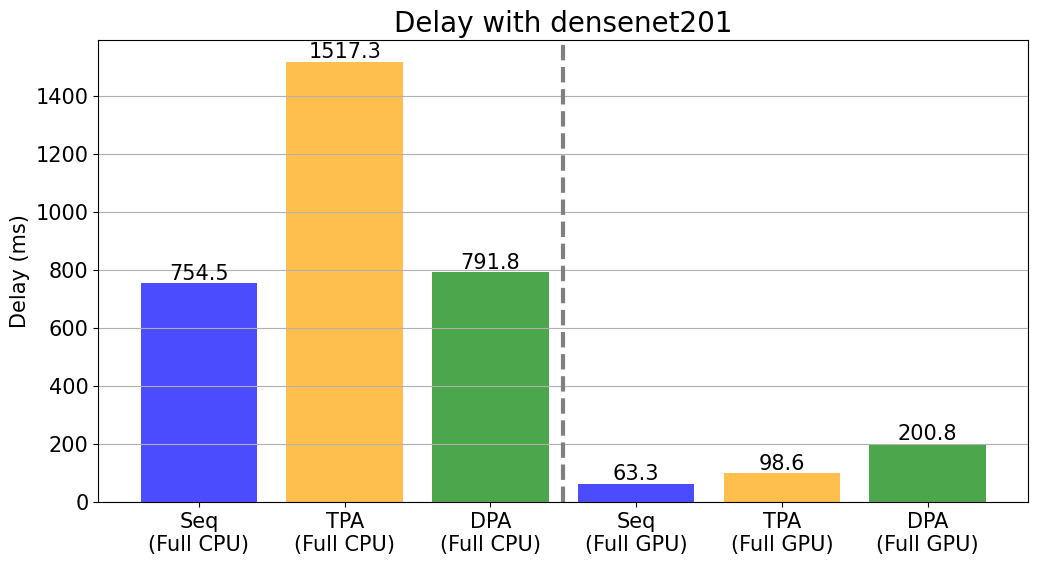

In [17]:
fig = plt.figure(figsize=(12, 6))

# 두 번째 그래프: Average Execution Time
bars2 = plt.bar(average_execution_times.keys(), average_execution_times.values(), color=colors[:3], alpha=0.7)
plt.ylabel('Delay (ms)', size = 15)
plt.title(f'Delay with {model}', size = 20)
plt.grid(True, axis = 'y')
plt.axvline(x=2.5, color='gray', linestyle='--', linewidth=3)  # x=2.5 위치에 점선 추가

# 막대 위에 텍스트 추가
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom', size = 15)
plt.tick_params(labelsize=15)

##### 3. Block Loss / Pipeline stall

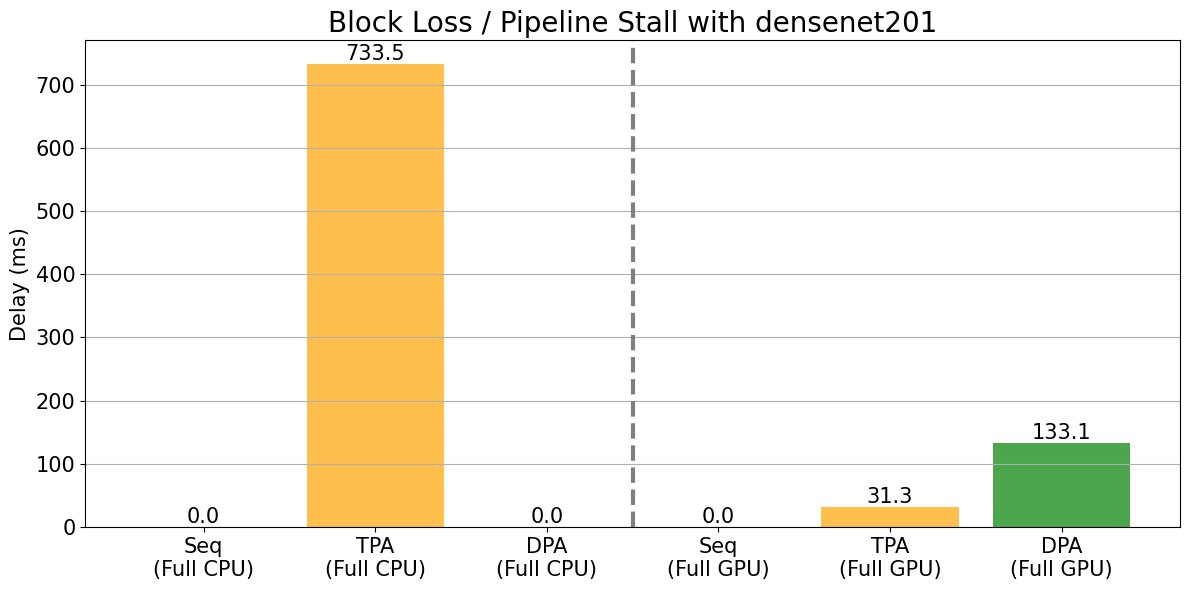

In [18]:
fig = plt.figure(figsize=(12, 6))

# tp 번째 그래프: Block Loss
bars3 = plt.bar(block_losses.keys(), block_losses.values(), color=colors[:3], alpha=0.7)
plt.ylabel('Delay (ms)', size = 15)
plt.title(f'Block Loss / Pipeline Stall with {model}', size = 20)
plt.grid(True, axis = 'y')
plt.axvline(x=2.5, color='gray', linestyle='--', linewidth=3)  # x=2.5 위치에 점선 추가

# 막대 위에 텍스트 추가
for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom', size = 15)
plt.tick_params(labelsize=15)
plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{model}/{save_format}/3.BlockLoss_{device}_{model}.{save_format}')

##### 4. Acceleration Gain

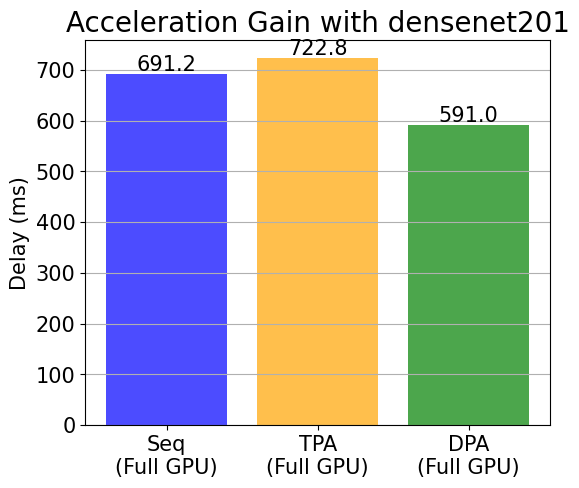

In [19]:
fig = plt.figure(figsize=(6, 5))

# 네 번째 그래프: Acceleration Gain
bars4 = plt.bar(accel_gains.keys(), accel_gains.values(), color=colors, alpha=0.7)
plt.ylabel('Delay (ms)', size = 15)
plt.title(f'Acceleration Gain with {model}', size = 20)
plt.grid(True, axis = 'y')
plt.tick_params(labelsize=15)

# 막대 위에 텍스트 추가
for bar in bars4:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom', size = 15)
plt.tick_params(labelsize=15)

##### 5. Delay Component

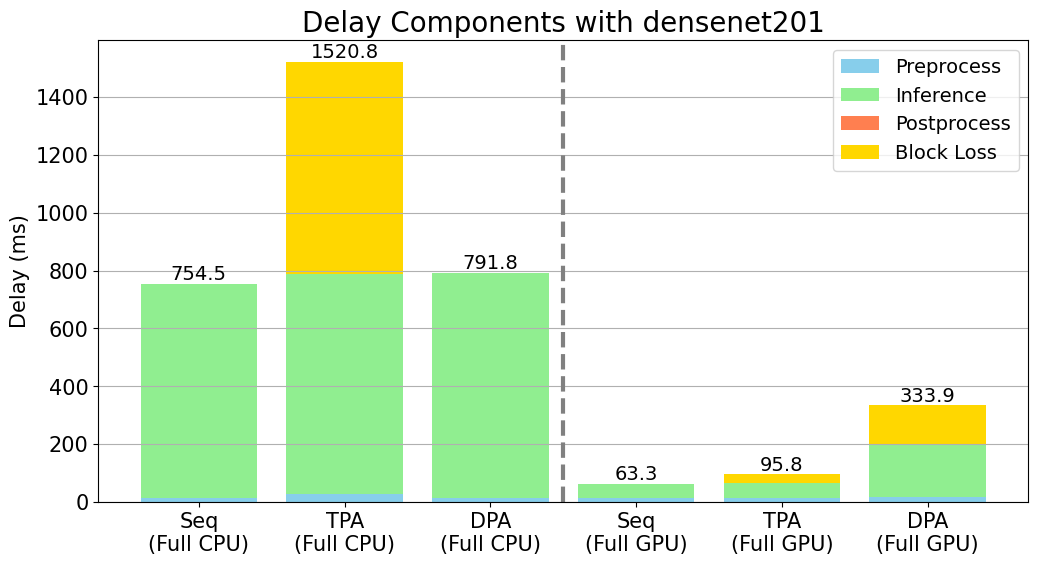

In [20]:
plt.figure(figsize=(12, 6))
x_labels = list(pre_components.keys())
pre_values = np.array(list(pre_components.values()))
infer_values = np.array(list(infer_components.values()))
post_values = np.array(list(post_components.values()))
block_values = np.array(list(block_components.values()))

# 첫 번째 그래프: Delay Components
bar1 = plt.bar(x_labels, pre_values, color='skyblue', label='Preprocess')
bar2 = plt.bar(x_labels, infer_values, color='lightgreen',bottom=np.array(pre_values), label='Inference')
bar3 = plt.bar(x_labels, post_values, bottom=np.array(pre_values) + np.array(infer_values), color='coral', label='Postprocess')
bar4 = plt.bar(x_labels, block_values,
               bottom=np.array(pre_values) + np.array(infer_values) + np.array(post_values),
               color='gold', label='Block Loss')

# 막대 위에 텍스트 추가
for i in range(6):
    total_height = (pre_values[i] + infer_values[i] +
                    post_values[i] + block_values[i])
    plt.text(i, total_height, f'{total_height:.1f}', ha='center', va='bottom', fontsize=14)

plt.legend(fontsize=14)
plt.ylabel('Delay (ms)', size = 15)
plt.title(f'Delay Components with {model}', size = 20)
plt.grid(True, axis = 'y')
plt.axvline(x=2.5, color='gray', linestyle='--', linewidth=3)  # x=2.5 위치에 점선 추가
plt.tick_params(labelsize=15)

In [21]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # 파일 경로 설정
# files = {
#     'Sequential': "../{save_format}/../{save_format}/csv/data-0106/sequential/densenet201/sequential_gpu_01core.csv",
#     'Pipeline': "../{save_format}/../{save_format}/csv/data-0106/pipeline/densenet201/pipeline_gpu.csv",
#     'Data-Parallel': "../{save_format}/../{save_format}/csv/data-0106/data_parallel/densenet201/data-parallel_gpu_4thread.csv"
# }

# # 데이터 저장을 위한 딕셔너리
# average_frame_rates = {}
# average_execution_times = {}

# # 파일 별로 데이터 로드 및 평균 계산
# for label, file_path in files.items():
#     data = pd.read_csv(file_path)
    
#     # frame_rate의 평균 계산
#     average_frame_rate = data['frame_rate'].mean()
#     average_frame_rates[label] = average_frame_rate
    
#     # execution_time의 평균 계산
#     average_execution_time = data['execution_time'].mean()
#     average_execution_times[label] = average_execution_time

# # 1행 2열 subplot 생성
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# # 첫 번째 그래프: Average Frame Rate
# bars1 = ax1.bar(average_frame_rates.keys(), average_frame_rates.values(), color='orange')
# #ax1.set_xlabel('File Type')
# ax1.set_ylabel('Frame rate (fps)', size = 30)
# #ax1.set_title('Average Frame Rate Comparison')
# ax1.set_xticklabels(average_frame_rates.keys())
# ax1.grid(True, axis = 'y')
# ax1.tick_params(labelsize=15)
# ax1.set_ylim(0,60)

# # 막대 위에 텍스트 추가
# for bar in bars1:
#     yval = bar.get_height()
#     ax1.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom', size = 15)

# # 두 번째 그래프: Average Execution Time
# bars2 = ax2.bar(average_execution_times.keys(), average_execution_times.values(), color='skyblue')
# #ax2.set_xlabel('File Type')
# ax2.set_ylabel('Delay (ms)', size = 30)
# #ax2.set_title('Average Execution Time Comparison')
# ax2.set_xticklabels(average_execution_times.keys())
# ax2.grid(True, axis = 'y')
# # ax2.set_ylim(0,700)
# # 막대 위에 텍스트 추가
# for bar in bars2:
#     yval = bar.get_height()
#     ax2.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom', size = 15)
# ax2.tick_params(labelsize=15)
# plt.tight_layout()
# plt.show()
